In [1]:
import simpegSP as SP
from SimPEG import Mesh, np
from SimPEG.EM import Static
%pylab inline

/Users/sgkang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
workdir = "/Users/sgkang/Dropbox/seogi/DamResearch/SP/data/drawdown_modeling/"
fname = "drawdown(0sec).csv"
fluiddata = SP.Utils.readSeepageModel(workdir+fname)

In [3]:
xyz =  fluiddata["xyz"]
h =  fluiddata["h"]
Sw =  fluiddata["Sw"]
Kx =  fluiddata["Kx"]
Ky =  fluiddata["Ky"]
P = fluiddata["P"]
Ux =  fluiddata["Ux"]
Uy =  fluiddata["Uy"]
mesh = fluiddata["mesh"]
xsurf, ysurf, yup = fluiddata["xsurf"], fluiddata["ysurf"], fluiddata["yup"]
hcc = fluiddata["hcc"]
actind = fluiddata["actind"]
waterind = fluiddata["waterind"]

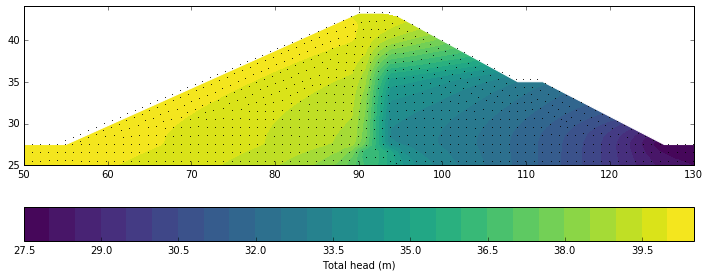

In [21]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(111)
dat = Static.Utils.plot2Ddata(xyz, h, ax=ax, ncontour=30, contourOpts={"cmap":"viridis"})
ax.fill_between(xsurf, ysurf, yup, facecolor='white', edgecolor="white")
ax.set_xlim(50, 130)
ax.set_ylim(25, 44)
cb = plt.colorbar(dat[1], orientation="horizontal")
cb.set_label("Total head (m)")

In [5]:
rho = np.ones(mesh.nC)*1e8
rho[actind] = 1000.
rho[waterind] = 100.

(<matplotlib.collections.QuadMesh at 0x11ca629d0>,)

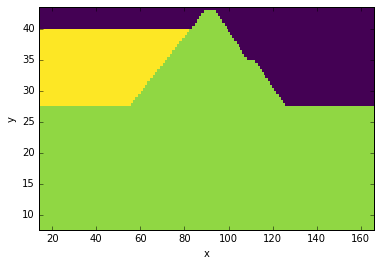

In [6]:
mesh.plotImage(np.log10(1./rho), pcolorOpts={"cmap":"viridis"})

In [7]:
tempx = np.r_[0. , 82, 125, 0., 0. ]
tempy = np.r_[40., 40, 27.5 , 27.5, 40.]
inds = SP.Utils.PolygonInd(mesh, np.c_[tempx, tempy])
satinds = (inds) & (actind)
# L = np.zeros(mesh.nC)
L = np.ones(mesh.nC)*1e-20
L[satinds] = 2.5*1e-4

(<matplotlib.collections.QuadMesh at 0x11cc9a590>,)

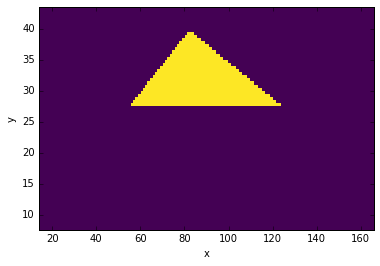

In [8]:
mesh.plotImage(satinds, pcolorOpts={"cmap":"viridis"})

In [9]:
from SimPEG import Utils

In [24]:
airind = ~np.logical_or(actind, waterind)
topo = np.c_[xsurf, ysurf]
pts = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>85, mesh.vectorCCx<120)]
locs = SP.Utils.drapeTopotoLoc(mesh, topo, pts)
locM = locs.copy()
locN = locs.copy()
locN = np.c_[np.ones(locs.shape[0])*locM[0,0], np.ones(locs.shape[0])*locM[0,1]]

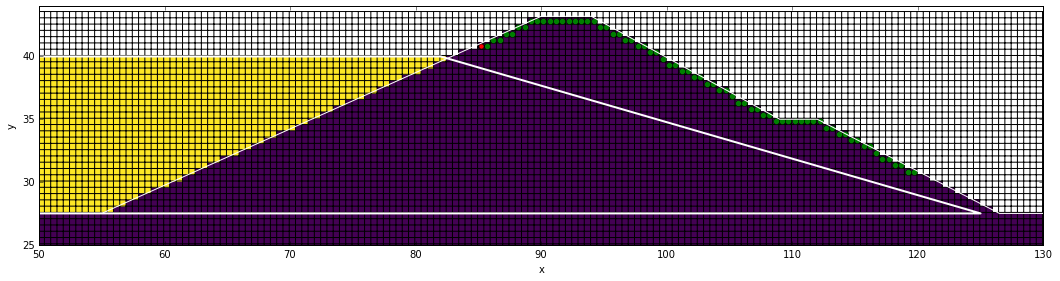

In [25]:
fig = plt.figure(figsize = (12*1.5, 5*1.5))
ax = plt.subplot(111)
sigma = 1./rho
sigma[airind] = np.nan
mesh.plotImage(np.log10(sigma), grid=True, pcolorOpts={"cmap":"viridis"}, ax=ax, clim=(-3, -2))
ax.plot(locM[:,0], locM[:,1], 'go')
ax.plot(locN[:,0], locN[:,1], 'ro', ms=5)
ax.plot(topo[:,0], topo[:,1], 'w-')
ax.plot(tempx, tempy, 'w-', lw=2)
ax.set_xlim(50, 130)
ax.set_ylim(25, 44)
# ax.plot(128, 27, 'wo', ms=5)
plt.gca().set_aspect('equal', adjustable='box')

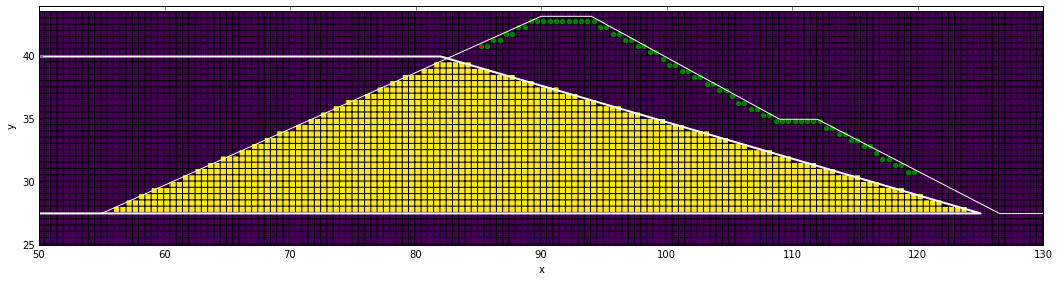

In [26]:
fig = plt.figure(figsize = (12*1.5, 5*1.5))
ax = plt.subplot(111)
sigma = 1./rho
sigma[airind] = np.nan
mesh.plotImage(L, grid=True, pcolorOpts={"cmap":"viridis"}, ax=ax)
ax.plot(locM[:,0], locM[:,1], 'go')
ax.plot(locN[:,0], locN[:,1], 'r.', ms=5)
ax.plot(topo[:,0], topo[:,1], 'w-')
ax.plot(tempx, tempy, 'w-', lw=2)
ax.set_xlim(50, 130)
ax.set_ylim(25, 44)
plt.gca().set_aspect('equal', adjustable='box')

In [27]:
prob = SP.Problem_CC(mesh, rho=rho)
rx = SP.Rx.Dipole(locM, locN)
src = SP.Src.StreamingCurrents([rx], L=L, mesh=mesh)
survey = SP.Survey([src])
survey.pair(prob)

In [28]:
f = prob.fields(hcc)
data = survey.dpred(hcc, f=f)

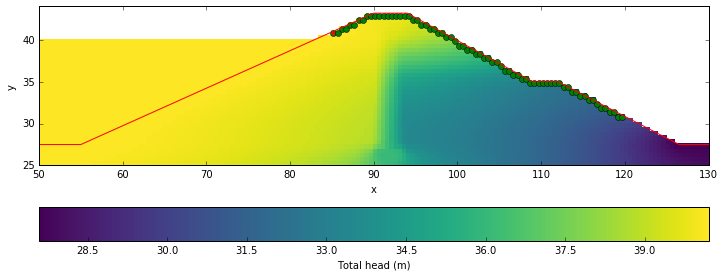

In [29]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(111)
temp = hcc.copy()
temp[airind] = np.nan
dat = mesh.plotImage(temp, grid=False, pcolorOpts={"cmap":"viridis"}, ax=ax, clim=(hcc.min(), hcc.max()) )
ax.plot(locM[:,0], locM[:,1], 'go')
ax.plot(locN[:,0], locN[:,1], 'r.', ms=5)
ax.plot(topo[:,0], topo[:,1], 'r-')
ax.set_xlim(50, 130)
ax.set_ylim(25, 44)
plt.gca().set_aspect('equal', adjustable='box')
cb = plt.colorbar(dat[0], orientation="horizontal")
cb.set_label("Total head (m)")

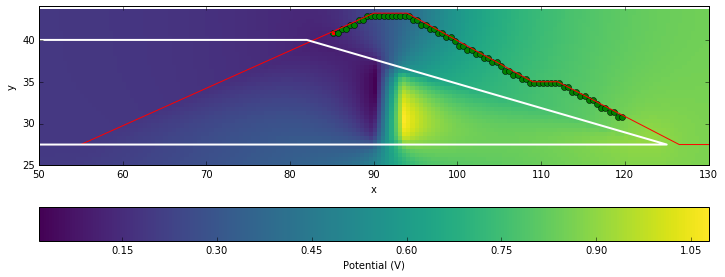

In [30]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(111)
sigma = 1./rho
sigma[airind] = np.nan
dat = mesh.plotImage(f[src,'phi'], grid=False, pcolorOpts={"cmap":"viridis"}, ax=ax)
ax.plot(locM[:,0], locM[:,1], 'go')
ax.plot(locN[:,0], locN[:,1], 'r.', ms=5)
ax.plot(topo[:,0], topo[:,1], 'r-')
ax.plot(tempx, tempy, 'w-', lw=2)

ax.set_xlim(50, 130)
ax.set_ylim(25, 44)
plt.gca().set_aspect('equal', adjustable='box')
cb = plt.colorbar(dat[0], orientation="horizontal")
cb.set_label("Potential (V)")

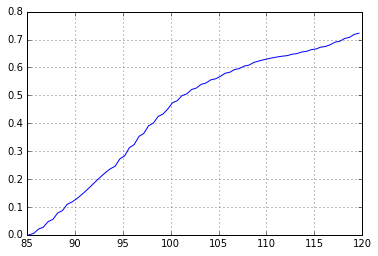

In [31]:
plt.plot(locs[:,0], data, '-')
grid(True)